In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math
import seaborn as sns

import jetson_configs as cfg
from src.ml_helpers.make_ml_dataset import *
from src.ml_helpers.make_baseline_models import *
from src.ml_helpers.fit_baseline_models import *
from src.ml_helpers.evaluate_models import *

# Get predictions

In [2]:
split_date     = cfg.train_test_split
current_month  = cfg.current_month

admin_level = "admin1"
horizon     = 1
fpath       = f'{admin_level}_lag{horizon}'

## Build the learning dataset

In [3]:
learn_df = make_ml_features(current_month, admin_level)

Dropped entirely missing columns:  []
Dropped duplicate columns:  ['miss_vegetation_cover_ndvi']


## Fit the models

In [4]:
predictions = fit_baseline_models(learn_df, admin_level, horizon)

## Score the models

In [5]:
months = sorted(learn_df.index.get_level_values('date').unique().tolist())
n = months.index(pd.to_datetime(split_date)) + 1
train_dates, test_dates = months[:n], months[n:]

In [6]:
results = evaluate_predictions(predictions, train_dates, test_dates,
                              admin_level, horizon)

/home/keh494/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/series.py:851: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


# Visualize the results

## Inspect the predictions for one region

Text(0.5, 1.0, 'Predictions for {region}')

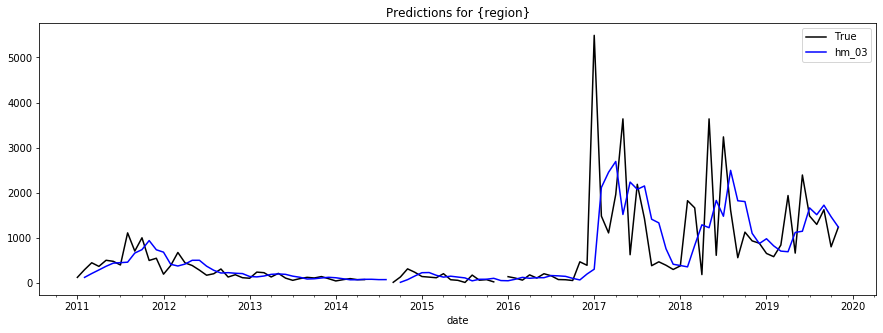

In [7]:
region     = 'Awdal'
model      = 'hm_03'
parameters = ''
plot_df    = predictions.xs("Awdal", level='region')[['true', model]]

ax = plot_df['true'].plot(color='black', figsize=[15,5], label='True', legend=True)
plot_df[model].plot(color='blue', ax=ax, label=model, legend=True)
ax.set_title("Predictions for {region}")

## View performance by train/test set

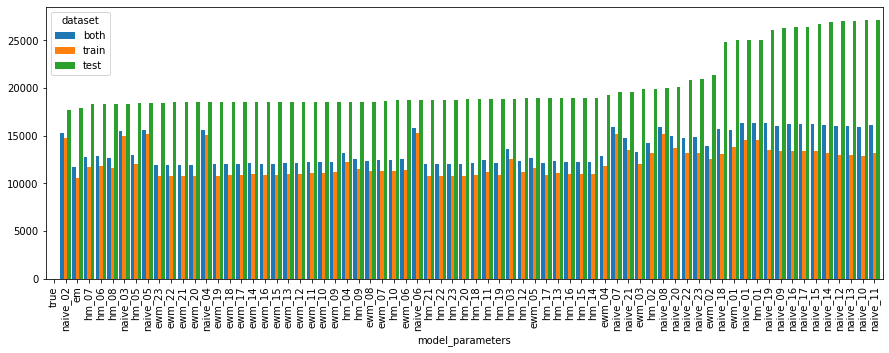

In [8]:
plot_df = results['all'].unstack(level='dataset').sort_values('test').xs("rmse", level="metric")
plot_df.plot(kind='bar', figsize=[15,5], width=.9)

## View actual error rates in best scenario

In [9]:
results['all'].unstack(level='dataset').xs("rmse", level="metric").sort_values('test', ascending=True).astype(int).head()

dataset,both,train,test
model_parameters,,,
true,0,0,0
naive_02,15237,14806,17714
em,11696,10571,17917
hm_07,12734,11724,18320
hm_06,12844,11856,18325


In [10]:
predictions['true'].mean()

3554.6181055155876

In [11]:
predictions['true'].std()

11277.813264380407

## View ranked results

In [12]:
results_for_ranking = results['all'].unstack(level='dataset').unstack(level=['metric'])["train"]

In [13]:
print("Best models - MAE  -----------------",  results_for_ranking['mae' ].sort_values().head(6).astype(int))
print("Best models - RMSE -----------------",  results_for_ranking['rmse'].sort_values().head(6).astype(int))
print("Best models - MAPE -----------------",  results_for_ranking['mape'].sort_values().head(6).round(2))


Best models - MAE  ----------------- model_parameters
true         0
em        3909
ewm_23    4257
ewm_22    4271
ewm_21    4284
ewm_20    4299
Name: mae, dtype: int64
Best models - RMSE ----------------- model_parameters
true          0
em        10571
hm_23     10733
ewm_23    10744
ewm_22    10759
hm_22     10764
Name: rmse, dtype: int64
Best models - MAPE ----------------- model_parameters
true       0.00
em        21.50
ewm_23    21.97
ewm_22    22.01
ewm_21    22.05
ewm_20    22.09
Name: mape, dtype: float64


## Explore performance of naive predictions over time

### EWM

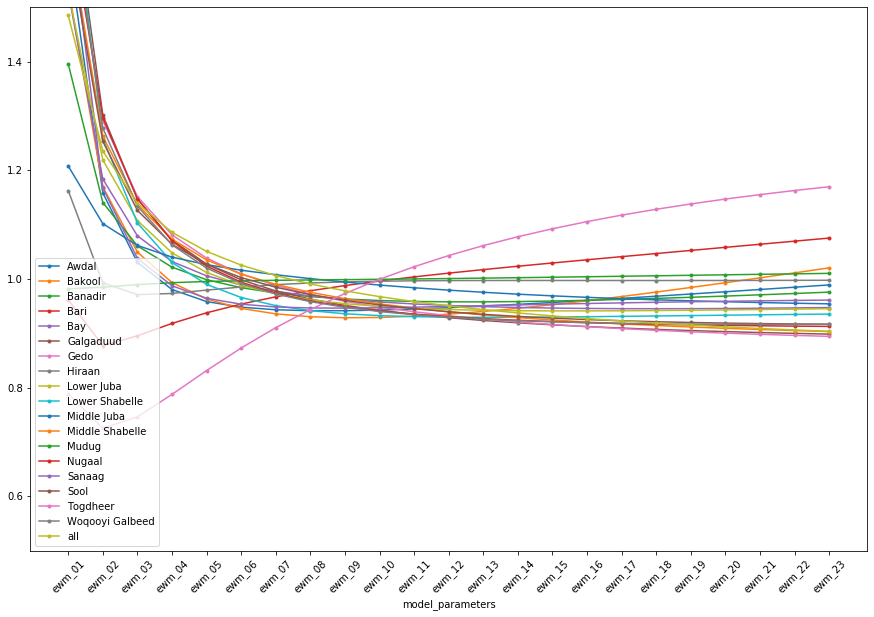

In [14]:
naive_predictions = [i for i in results_for_ranking.index.tolist() if 'ewm_' in i]

plot_df = results.loc[naive_predictions, 'mse', 'train']

plot_df = (plot_df/plot_df.mean()).reset_index(level=['metric', 'dataset'], drop=True)

ax = plot_df.plot(marker=".", figsize=[15,10], ylim=[0.5,1.5], rot=45)

ax.set_xticks(range(len(plot_df.index.get_level_values(0))))
ax.set_xticklabels(plot_df.index.get_level_values(0))
plt.show()

### HM

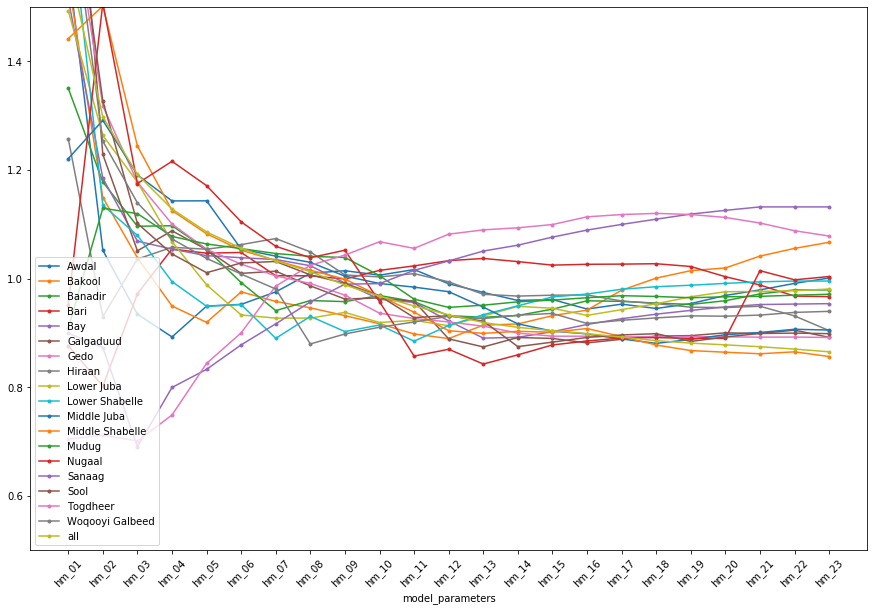

In [15]:
naive_predictions = [i for i in results_for_ranking.index.tolist() if 'hm_' in i]

plot_df = results.loc[naive_predictions, 'mse', 'train']

plot_df = (plot_df/plot_df.mean()).reset_index(level=['metric', 'dataset'], drop=True)

ax = plot_df.plot(marker=".", figsize=[15,10], ylim=[0.5,1.5], rot=45)

ax.set_xticks(range(len(plot_df.index.get_level_values(0))))
ax.set_xticklabels(plot_df.index.get_level_values(0))
plt.show()

## View error metrics by region and model

### Raw error metrics

#### MSE

/home/keh494/.conda/envs/py37/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


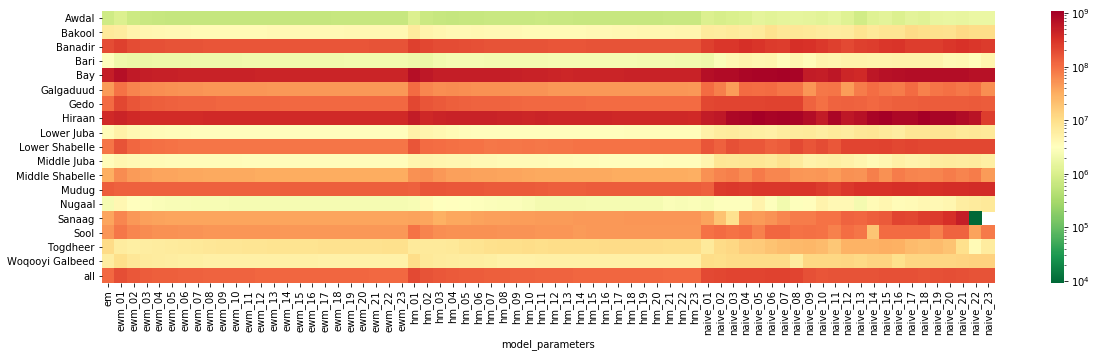

In [16]:
fig, ax = plt.subplots(1,1, figsize=[20,5])
plot_df = results.xs(['mse', 'train'], level=['metric', 'dataset']).astype(float).drop(['true']) + 1

min_flow, max_flow = plot_df.min().min(), plot_df.max().max()
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(min_flow)), 
                                             1+math.ceil(math.log10(max_flow)))]
sns.heatmap(plot_df.T, 
            norm=LogNorm(vmin=min_flow, vmax=max_flow), # Norm the colormap
            cbar_kws={"ticks": cbar_ticks},
            ax=ax, cmap='RdYlGn_r')

plt.savefig("figures/naive_raw_mse.png", dpi=100, bbox_inches="tight")

#### MAE

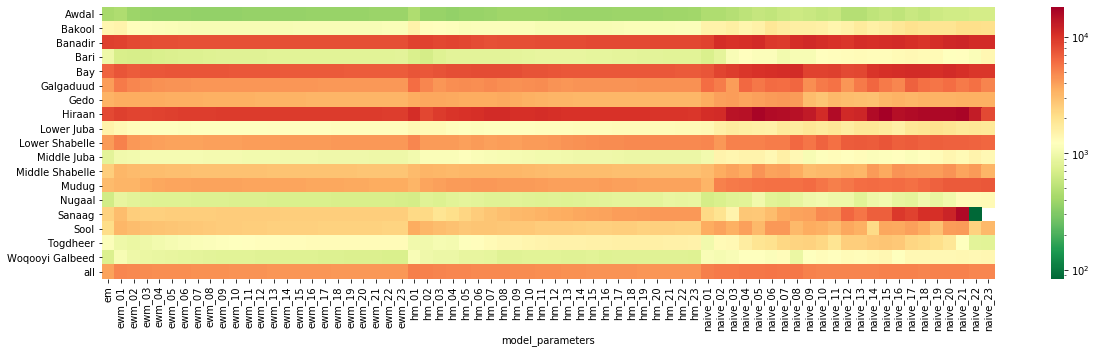

In [17]:
fig, ax = plt.subplots(1,1, figsize=[20,5])
plot_df = results.xs(['mae', 'train'], level=['metric', 'dataset']).astype(float).drop(['true']) + 1

min_flow, max_flow = plot_df.min().min(), plot_df.max().max()
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(min_flow)), 
                                             1+math.ceil(math.log10(max_flow)))]
sns.heatmap(plot_df.T, 
            norm=LogNorm(vmin=min_flow, vmax=max_flow), # Norm the colormap
            cbar_kws={"ticks": cbar_ticks},
            ax=ax, cmap='RdYlGn_r')

#### MAPE

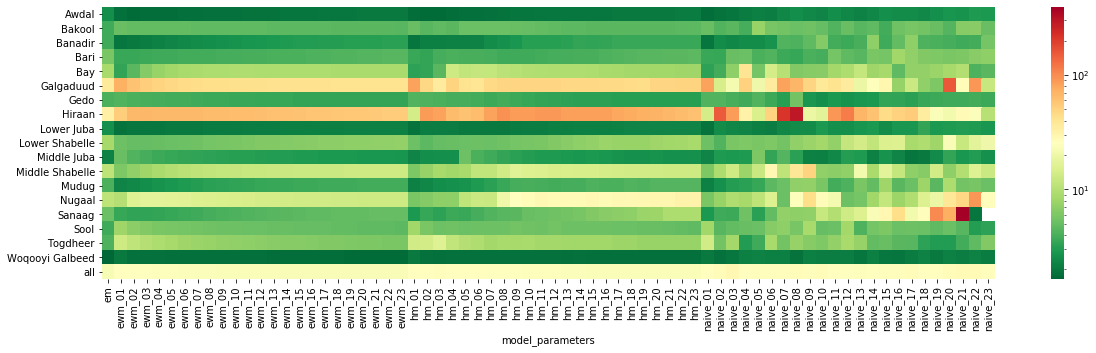

In [18]:
fig, ax = plt.subplots(1,1, figsize=[20,5])
plot_df = results.xs(['mape', 'train'], level=['metric', 'dataset']).astype(float).drop(['true']) + 1

min_flow, max_flow = plot_df.min().min(), plot_df.max().max()
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(min_flow)), 
                                             1+math.ceil(math.log10(max_flow)))]
sns.heatmap(plot_df.T, 
            norm=LogNorm(vmin=min_flow, vmax=max_flow), # Norm the colormap
            cbar_kws={"ticks": cbar_ticks},
            ax=ax, cmap='RdYlGn_r')

In [19]:
min_flow

1.6570531969128426

In [20]:
max_flow

393.20476190476194

### Ranked error metrics

#### MSE

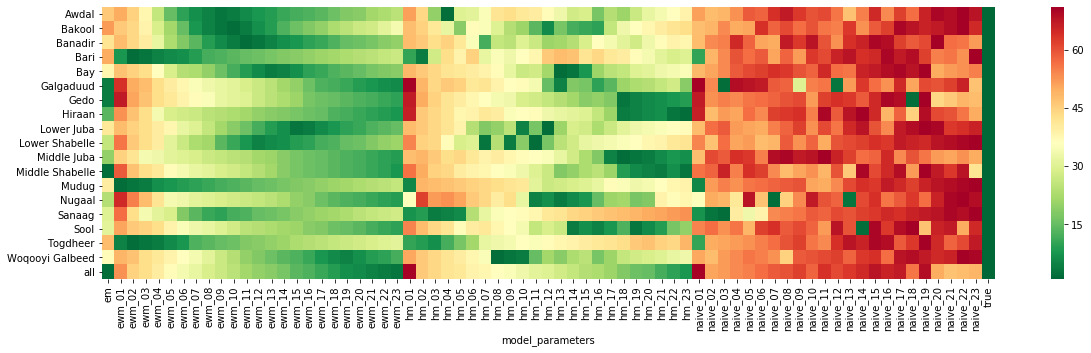

In [21]:
fig, ax = plt.subplots(1,1, figsize=[20,5])
plot_df =  results.xs(['mse', 'both'], level=['metric', 'dataset']).astype(float).rank(axis=0) #.sort_values('all')
sns.heatmap(plot_df.T, ax=ax, cmap='RdYlGn_r')
plt.savefig("figures/naive_ranked_mse.png", dpi=100, bbox_inches="tight")

#### RMSE

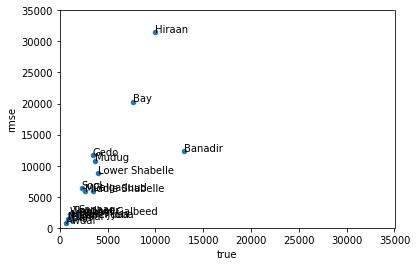

In [22]:
plot_df = pd.concat([
    results[results.index.get_level_values(0)!='true'].xs(['rmse', 'both'], level=['metric', 'dataset']).min(),
    predictions.unstack(level='region')['true'].mean()
    ], axis=1, sort=True)

plot_df.columns=['rmse', 'true']


ax = plot_df.plot(kind='scatter', x='true', y='rmse', xlim=[0,35000], ylim=[0,35000])

for i, row in plot_df.iterrows():
    ax.annotate(i, (row.true, row.rmse))

### Distribution of error metrics

#### By model

In [23]:
models1 = list(set( [i for i in results.index.get_level_values("model_parameters") if "ewm" in i]))
plot_df1 = results.loc[models1].xs("mse", level="metric").xs("train", level="dataset").stack()

In [24]:
models2 = list(set( [i for i in results.index.get_level_values("model_parameters") if "hm" in i]))
plot_df2 = results.loc[models2].xs("mse", level="metric").xs("train", level="dataset").stack()

In [25]:
models3 = list(set( [i for i in results.index.get_level_values("model_parameters") if "naive" in i]))
plot_df3 = results.loc[models3].xs("mse", level="metric").xs("train", level="dataset").stack()

No handles with labels found to put in legend.


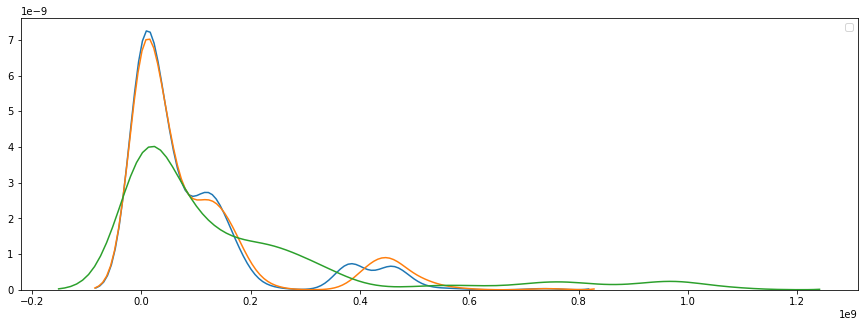

In [26]:
fig,ax=plt.subplots(1,1, figsize=[15,5])

sns.kdeplot(plot_df1, ax=ax)
sns.kdeplot(plot_df2, ax=ax)
sns.kdeplot(plot_df3, ax=ax)

ax.legend()

#### By region, for EWM model

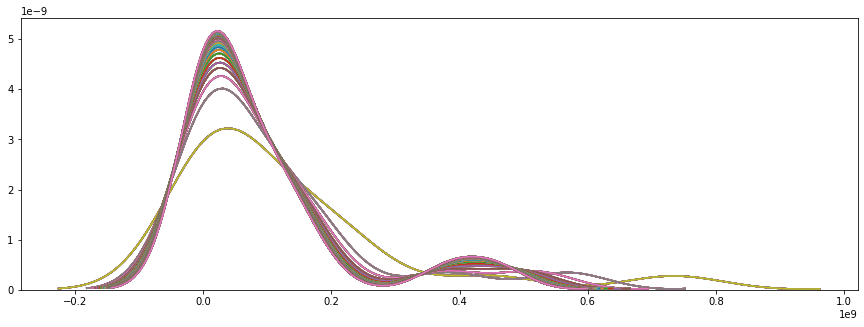

In [27]:
fig,ax=plt.subplots(1,1, figsize=[15,5])

for ewm in plot_df1.index.get_level_values(0):
    sns.kdeplot(plot_df1.loc[ewm], ax=ax, legend=False)